In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


from imblearn.over_sampling import RandomOverSampler
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    log_loss,
    confusion_matrix,
    classification_report,
    average_precision_score,
    auc
)
import time
import joblib
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

np.random.seed(0)

In [21]:
df = pd.read_csv("Dataset_2_DATA.csv", encoding='cp1251')[lambda df: df['DAGSOORT'] == 1]
df_d = pd.read_csv("Dataset_2_DESCRIPTION.csv", encoding='cp1251')

## –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö

### 1. –û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π 

In [22]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º –Ω–∞ —Å–æ–¥–µ—Ä–∂–∞–Ω–∏–µ NaN-–∑–Ω–∞—á–µ–Ω–∏–π
has_any_missing = df.isna().any().any()
print("–ï—Å—Ç—å –ª–∏ NaN –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ?", has_any_missing)

# –ú–æ–∂–µ—Ç –ø–æ–∫–∞–∑–∞—Ç—å—Å—è, —á—Ç–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –Ω–µ—Ç, –Ω–æ –µ—Å–ª–∏ –ø—Ä–æ–≤–µ—Ä–∏—Ç—å —Å—Ç–æ–ª–±—Ü—ã –Ω–∞ —Å–æ–æ—Ç–≤–µ—Å—Ç–≤–∏–µ —Ç–∏–ø—É object –º–æ–∂–Ω–æ –ø–æ–Ω—è—Ç—å,
# —á—Ç–æ –¥–≤–∞ —Å—Ç–æ–ª–±—Ü–∞ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω–æ –º–æ–≥—É—Ç —Å–æ–¥–µ—Ä–∂–∞—Ç—å "–Ω–µ—Ç–∏–ø–∏—á–Ω—ã–µ" –ø—Ä–æ–ø—É—Å–∫–∏.
print(df.dtypes[df.dtypes != 'int64'])

# –ü—Ä–æ–≤–µ—Ä–∏–º —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è —Å—Ç–æ–ª–±—Ü–æ–≤ KREISDUUR –∏ PARKEERKOSTEN
for col in df.select_dtypes(include=['object']).columns:
    print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ {col}:")
    print(df[col].unique())

# –ë–∏–Ω–≥–æ! –ü—Ä–æ–ø—É—Å–∫–∏ –≤ –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö –æ–±–æ–∑–Ω–∞—á–∞—é—Ç—Å—è –æ–¥–Ω–∏–º –ø—Ä–æ–±–µ–ª–æ–º(' ')

–ï—Å—Ç—å –ª–∏ NaN –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ? False
KREISDUUR        object
PARKEERKOSTEN    object
dtype: object
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ KREISDUUR:
['11' '8' '7' '5' '4' '3' '10' '6' '2' '9' ' ' '1']
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ PARKEERKOSTEN:
['0' '9' '3' '11' ' ' '13' '5' '4' '14' '12' '16' '10' '7' '2' '6' '1' '8']


In [23]:
# –ó–∞–º–µ–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ –Ω–∞ NaN-–∑–Ω–∞—á–µ–Ω–∏–µ
df = df.replace({' ': np.nan})

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–º–µ–Ω—ã –ø—Ä–æ–ø—É—Å–∫–æ–≤ –º–æ–¥–æ–π (–∏–ª–∏ —Å—Ä–µ–¥–Ω–∏–º) –∑–Ω–∞—á–µ–Ω–∏–µ–º
def fill_with_mode(group):
    mode_vals = group.mode()
    if not mode_vals.empty:
        return group.fillna(mode_vals.iloc[0])
    return group.fillna(group.mean())

# –ó–∞–º–µ–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ –≤ –Ω–∞–π–¥–µ–Ω–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–∞—Ö
cols_to_fill = ['KREISDUUR', 'PARKEERKOSTEN']
for col in cols_to_fill:
    df[col] = df.groupby('PERSID')[col].transform(fill_with_mode)

### 2. –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤

In [24]:
df = df.drop_duplicates()
display(df) # –ö–∞–∫ –º–æ–∂–Ω–æ –∑–∞–º–µ—Ç–∏—Ç—å, –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –Ω–µ –∏–∑–º–µ–Ω–∏–ª–æ—Å—å
print(df.info())

HHID      PERSID     VPLID       RitID  HH_VALID  P_VALID  KHVM  \
0     30055622  3005562201  13957101  1395710101         2        3     2   
1     30055622  3005562201  13957102  1395710201         2        3     2   
2     30055622  3005562201  13957201  1395720101         2        3     1   
3     30055622  3005562201  13957202  1395720201         2        3     1   
7     30356310  3035631001  17204101  1720410101         2        3     8   
...        ...         ...       ...         ...       ...      ...   ...   
7304  30862294  3086229401  19042102  1904210201         2        3     1   
7306  30862294  3086229401  19042103  1904210301         2        3     7   
7307  30862294  3086229401  19042104  1904210401         2        3     7   
7308  30862294  3086229401  19042201  1904220101         2        3     1   
7309  30862294  3086229401  19042105  1904210501         2        3     1   

      WEGGEWEEST  VERTREKP  AANTVPL  ...  HHAUTO_N  HHAUTO  HHBESTEL  \
0              1         2        2  ...         3       1         0   
1              1         2        2  ...         3       1         0   
2              1         2        4  ...         3       1         0   
3              1         2        4  ...         3       1         0   
7              1         2        1  ...         2       1         0   
...          ...       ...      ...  ...       ...     ...       ...   
7304           1         2        5  ...         1       1         0   
7306           1         2        5  ...         1       1         0   
7307           1         2        5  ...         1       1         0   
7308           1         2        3  ...         1       1         0   
7309           1         2        5  ...         1       1         0   

      HHHYBRID  HHMOTOR  HHBROM  HHSNOR  HHFIETS  HHVOUWFIETS  HHEBIKE  
0            0        1       0       0        1            0        1  
1            0        1       0       0        1            0        1  
2            0        1       0       0        1            0        1  
3            0        1       0       0        1            0        1  
7            0        0       0       0        0            0        1  
...        ...      ...     ...     ...      ...          ...      ...  
7304         0        0       0       0        1            0        0  
7306         0        0       0       0        1            0        0  
7307         0        0       0       0        1            0        0  
7308         0        0       0       0        1            0        0  
7309         0        0       0       0        1            0        0  

[5700 rows x 56 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   HHID                     5700 non-null   int64 
 1   PERSID                   5700 non-null   int64 
 2   VPLID                    5700 non-null   int64 
 3   RitID                    5700 non-null   int64 
 4   HH_VALID                 5700 non-null   int64 
 5   P_VALID                  5700 non-null   int64 
 6   KHVM                     5700 non-null   int64 
 7   WEGGEWEEST               5700 non-null   int64 
 8   VERTREKP                 5700 non-null   int64 
 9   AANTVPL                  5700 non-null   int64 
 10  VPLDAGNR                 5700 non-null   int64 
 11  VERPL                    5700 non-null   int64 
 12  VERPLNR                  5700 non-null   int64 
 13  TOER                     5700 non-null   int64 
 14  TOER_TYPE                5700 non-null   int6

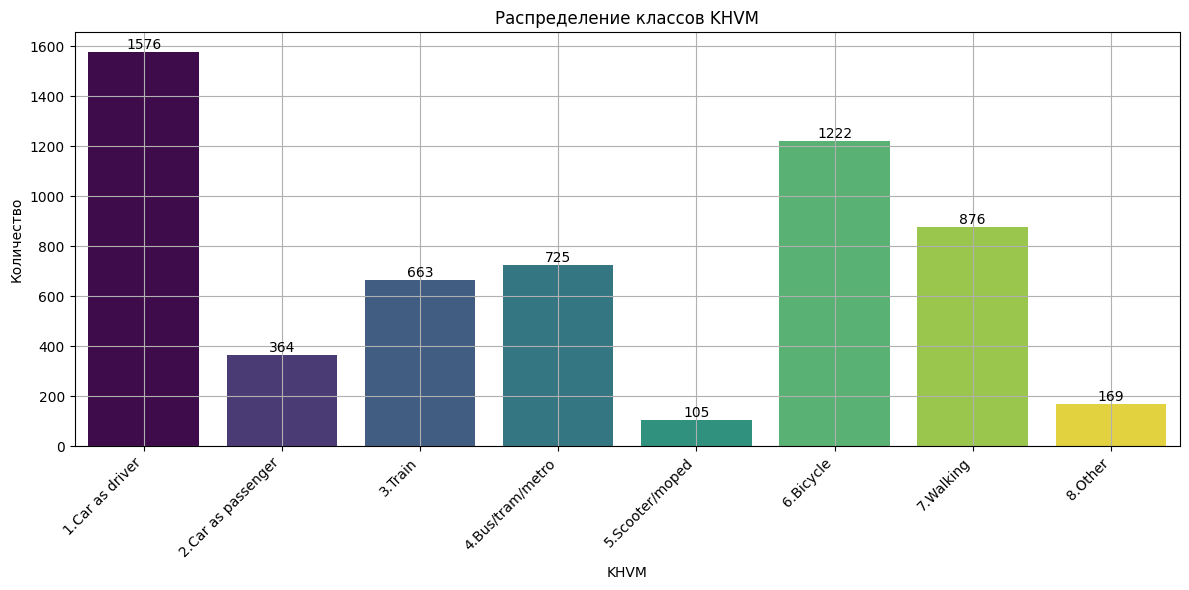

In [25]:
labels = {
    1: '1.Car as driver',
    2: '2.Car as passenger',
    3: '3.Train',
    4: '4.Bus/tram/metro',
    5: '5.Scooter/moped',
    6: '6.Bicycle',
    7: '7.Walking',
    8: '8.Other'
}


# –ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∏–∑–º–µ—Ä–µ–Ω–∏–π –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
class_counts = df['KHVM'].value_counts().sort_index()

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤ KHVM
plt.figure(figsize=(12, 6))
sns.countplot(x=df['KHVM'], hue=df['KHVM'], palette='viridis', legend=False)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ KHVM')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')

# –£—Å—Ç–∞–Ω–æ–≤–∫–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏—Ö –º–µ—Ç–æ–∫ –Ω–∞ –æ—Å–∏ X
plt.xticks(ticks=range(len(labels)), labels=[labels[i] for i in range(1, 9)], rotation=45, ha='right')

# –î–æ–±–∞–≤–ª–µ–Ω–∏–µ —Ç–µ–∫—Å—Ç–∞ —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –∏–∑–º–µ—Ä–µ–Ω–∏–π –Ω–∞–¥ –∫–∞–∂–¥—ã–º —Å—Ç–æ–ª–±—Ü–æ–º
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.grid(True)
plt.tight_layout()

In [27]:
# 1. –í—Ä–µ–º—è —Å—É—Ç–æ–∫
def get_time_of_day(kverttijd):
    if kverttijd in [1, 2, 3, 4]:  # 0:00‚Äì9:00
        return 'morning'
    elif kverttijd in [5, 6, 7, 8]:  # 9:00‚Äì16:00
        return 'day'
    elif kverttijd in [9, 10, 11, 12, 13]:  # 16:00‚Äì24:00
        return 'evening'
    else:
        return 'unknown'
df['time_of_day'] = df['KVERTTIJD'].apply(get_time_of_day)

# 2. –ú–∞—Ä—à—Ä—É—Ç –ø–æ –ø—Ä–æ–≤–∏–Ω—Ü–∏—è–º
df['province_route'] = df['VERTPROV'].astype(str) + '_' + df['AANKPROV'].astype(str)

df['KREISDUUR'] = pd.to_numeric(df['KREISDUUR'], errors='coerce')

# 2. –ß–∏—Å–ª–æ–≤–∞—è –¥–ª–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –ø–æ–µ–∑–¥–∫–∏ (KREISDUUR)
duration_map = {
    1: 2.5, 2: 7.5, 3: 12.5, 4: 17.5, 5: 22.5, 6: 27.5, 
    7: 37.5, 8: 52.5, 9: 75, 10: 105, 11: 120
}
df['travel_duration'] = df['KREISDUUR'].map(duration_map)

display(df)

HHID      PERSID     VPLID       RitID  HH_VALID  P_VALID  KHVM  \
0     30055622  3005562201  13957101  1395710101         2        3     2   
1     30055622  3005562201  13957102  1395710201         2        3     2   
2     30055622  3005562201  13957201  1395720101         2        3     1   
3     30055622  3005562201  13957202  1395720201         2        3     1   
7     30356310  3035631001  17204101  1720410101         2        3     8   
...        ...         ...       ...         ...       ...      ...   ...   
7304  30862294  3086229401  19042102  1904210201         2        3     1   
7306  30862294  3086229401  19042103  1904210301         2        3     7   
7307  30862294  3086229401  19042104  1904210401         2        3     7   
7308  30862294  3086229401  19042201  1904220101         2        3     1   
7309  30862294  3086229401  19042105  1904210501         2        3     1   

      WEGGEWEEST  VERTREKP  AANTVPL  ...  HHHYBRID  HHMOTOR  HHBROM  HHSNOR  \
0              1         2        2  ...         0        1       0       0   
1              1         2        2  ...         0        1       0       0   
2              1         2        4  ...         0        1       0       0   
3              1         2        4  ...         0        1       0       0   
7              1         2        1  ...         0        0       0       0   
...          ...       ...      ...  ...       ...      ...     ...     ...   
7304           1         2        5  ...         0        0       0       0   
7306           1         2        5  ...         0        0       0       0   
7307           1         2        5  ...         0        0       0       0   
7308           1         2        3  ...         0        0       0       0   
7309           1         2        5  ...         0        0       0       0   

      HHFIETS  HHVOUWFIETS  HHEBIKE  time_of_day  province_route  \
0           1            0        1          day             0_0   
1           1            0        1      evening             0_0   
2           1            0        1          day             0_0   
3           1            0        1          day             0_0   
7           0            0        1          day             0_0   
...       ...          ...      ...          ...             ...   
7304        1            0        0      morning           27_20   
7306        1            0        0          day           20_20   
7307        1            0        0          day           20_20   
7308        1            0        0      morning           22_20   
7309        1            0        0      evening           20_22   

      travel_duration  
0               120.0  
1                52.5  
2                37.5  
3                22.5  
7               120.0  
...               ...  
7304            105.0  
7306              7.5  
7307              7.5  
7308             27.5  
7309             22.5  

[5700 rows x 59 columns]

### 3. –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –¥–∞–Ω–Ω—ã—Ö

In [28]:
# –î–ª—è –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Ä–∞–±–æ—Ç—ã LightAutoML –Ω—É–∂–Ω–æ –ø–µ—Ä–µ–≤–µ—Å—Ç–∏ int64-—Å—Ç–æ–ª–±—Ü—ã –∫ category
# –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏ –∏—Ö —Ç–∏–ø–æ–≤
var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

# –°–ø–∏—Å–æ–∫ –Ω–æ–≤—ã—Ö —Ñ–∏—á
new_features = [
    'time_of_day',
    'province_route',
    'is_round_trip',
    'is_abroad',
    'has_car',
    'has_bike',
    'has_ebike'
]

# –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏ –∏—Ö —Ç–∏–ø–æ–≤ –∏–∑ –º–µ—Ç–∞–¥–∞–Ω–Ω—ã—Ö
var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

# –î–æ–±–∞–≤–∏–º –Ω–æ–≤—ã–µ —Ñ–∏—á–∏ –∫–∞–∫ Nominal –≤ var_types
new_features_df = pd.DataFrame({
    'Variable': new_features,
    'Measurement_level': 'Nominal'
})
var_types = pd.concat([var_types, new_features_df], ignore_index=True).drop_duplicates(subset='Variable')

# –°–æ–ø–æ—Å—Ç–∞–≤–∏–º —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞
matched_columns = pd.DataFrame(df.columns, columns=['Variable'])
merged = matched_columns.merge(var_types, on='Variable', how='left')

# –î–µ–ª–∞–µ–º —Å–ø–∏—Å–∫–∏ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö
nominal_cols = list(merged[merged['Measurement_level'] == 'Nominal']['Variable'])
ordinal_cols = list(merged[merged['Measurement_level'] == 'Ordinal']['Variable'])
scale_cols = list(merged[merged['Measurement_level'] == 'Scale']['Variable'])

# –£–¥–∞–ª–µ–Ω–∏–µ –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä–æ–≤
id_cols = ['HHID', 'PERSID', 'VPLID', 'RitID']
df = df.drop(columns=id_cols, errors='ignore')

# –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –∫ category –¥–ª—è Nominal –∏ Ordinal
for col in nominal_cols + ordinal_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ç–∏–ø–æ–≤
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   HH_VALID                 5700 non-null   category
 1   P_VALID                  5700 non-null   category
 2   KHVM                     5700 non-null   category
 3   WEGGEWEEST               5700 non-null   category
 4   VERTREKP                 5700 non-null   category
 5   AANTVPL                  5700 non-null   category
 6   VPLDAGNR                 5700 non-null   category
 7   VERPL                    5700 non-null   category
 8   VERPLNR                  5700 non-null   category
 9   TOER                     5700 non-null   category
 10  TOER_TYPE                5700 non-null   category
 11  AANTRIT                  5700 non-null   category
 12  KMOTIEF                  5700 non-null   category
 13  VERTPROV                 5700 non-null   category
 14  AANKPROV     

#### **–¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è (—Ç–∞—Ä–≥–µ—Ç):**
**`KHVM`** ‚Äî –∫–ª–∞—Å—Å –æ—Å–Ω–æ–≤–Ω–æ–≥–æ –≤–∏–¥–∞ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞ –¥–ª—è –ø–æ–µ–∑–¥–∫–∏. 

–ö–∞—Ç–µ–≥–æ—Ä–∏–∏:
1. Car as driver (–í–æ–¥–∏—Ç–µ–ª—å –∞–≤—Ç–æ–º–æ–±–∏–ª—è)
2. Car as passenger (–ü–∞—Å—Å–∞–∂–∏—Ä –∞–≤—Ç–æ–º–æ–±–∏–ª—è)
3. Train (–ü–æ–µ–∑–¥)
4. Bus/tram/metro (–ê–≤—Ç–æ–±—É—Å/—Ç—Ä–∞–º–≤–∞–π/–º–µ—Ç—Ä–æ)
5. Scooter/moped (–°–∫—É—Ç–µ—Ä/–º–æ–ø–µ–¥)
6. Bicycle (–í–µ–ª–æ—Å–∏–ø–µ–¥)
7. Walking (–ü–µ—à–∫–æ–º)
8. Other (–î—Ä—É–≥–æ–µ).

#### 1. **–î–µ–º–æ–≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∏–µ –∏ –¥–æ–º–æ—Ö–æ–∑—è–π—Å—Ç–≤–µ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ:**
- **`HHSAM`** ‚Äî —Å–æ—Å—Ç–∞–≤ –¥–æ–º–æ—Ö–æ–∑—è–π—Å—Ç–≤–∞ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –Ω–∞–ª–∏—á–∏–µ –¥–µ—Ç–µ–π –º–æ–∂–µ—Ç –≤–ª–∏—è—Ç—å –Ω–∞ –≤—ã–±–æ—Ä —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞).
- **`HHBRUTOINK2_w5`** ‚Äî –¥–æ—Ö–æ–¥ –¥–æ–º–æ—Ö–æ–∑—è–π—Å—Ç–≤–∞ (–≤—ã—Å–æ–∫–∏–π –¥–æ—Ö–æ–¥ –º–æ–∂–µ—Ç –∫–æ—Ä—Ä–µ–ª–∏—Ä–æ–≤–∞—Ç—å —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –∞–≤—Ç–æ–º–æ–±–∏–ª—è).
- **`HHAUTO`, `HHBESTEL`, `HHHYBRID`, `HHMOTOR`, `HHBROM`, `HHSNOR`, `HHFIETS`, `HHVOUWFIETS`, `HHEBIKE`** ‚Äî –ù–∞–ª–∏—á–∏–µ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–Ω—ã—Ö —Å—Ä–µ–¥—Å—Ç–≤.

#### 2. **–ì–µ–æ–≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∏–µ –∏ –∏–Ω—Ñ—Ä–∞—Å—Ç—Ä—É–∫—Ç—É—Ä–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ:**
- **`STED_GM`** ‚Äî —É—Ä–æ–≤–µ–Ω—å —É—Ä–±–∞–Ω–∏–∑–∞—Ü–∏–∏ (–≤–ª–∏—è–µ—Ç –Ω–∞ –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç—å –æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞).
- **`PROV`** ‚Äî –ø—Ä–æ–≤–∏–Ω—Ü–∏—è (—Ä–µ–≥–∏–æ–Ω–∞–ª—å–Ω—ã–µ —Ä–∞–∑–ª–∏—á–∏—è –≤ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–Ω—ã—Ö –ø—Ä–∏–≤—ã—á–∫–∞—Ö).
- **`vlokatie_station`** ‚Äî —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –¥–æ –±–ª–∏–∂–∞–π—à–µ–π –∂/–¥ —Å—Ç–∞–Ω—Ü–∏–∏.
- **`vlokatie_bushalte4xpu`** ‚Äî —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –¥–æ —á–∞—Å—Ç–æ —Ö–æ–¥—è—â–µ–≥–æ –∞–≤—Ç–æ–±—É—Å–∞.

#### 3. **–•–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –ø–æ–µ–∑–¥–∫–∏:**
- **`KAFSTV`** ‚Äî –∫–ª–∞—Å—Å —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –ø–æ–µ–∑–¥–∫–∏ (–∫–æ—Ä–æ—Ç–∫–∏–µ –ø–æ–µ–∑–¥–∫–∏ —á–∞—â–µ –Ω–∞ –≤–µ–ª–æ—Å–∏–ø–µ–¥–µ/–ø–µ—à–∫–æ–º).
- **`KVERTTIJD`** ‚Äî –≤—Ä–µ–º—è –Ω–∞—á–∞–ª–∞ –ø–æ–µ–∑–¥–∫–∏ (–ø–∏–∫–æ–≤—ã–µ —á–∞—Å—ã –º–æ–≥—É—Ç –≤–ª–∏—è—Ç—å –Ω–∞ –≤—ã–±–æ—Ä —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞).
- **`DOEL`** ‚Äî —Ü–µ–ª—å –ø–æ–µ–∑–¥–∫–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Ä–∞–±–æ—Ç–∞, —à–æ–ø–∏–Ω–≥).
- **`MOTIEF`** ‚Äî –º–æ—Ç–∏–≤ –ø–æ–µ–∑–¥–∫–∏ (–¥–µ–ª–æ–≤–æ–π, leisure –∏ —Ç.–¥.).
- **`TOER`** ‚Äî —è–≤–ª—è–µ—Ç—Å—è –ª–∏ –ø–æ–µ–∑–¥–∫–∞ –∫—Ä—É–≥–æ–≤–æ–π (–º–æ–∂–µ—Ç –≤–ª–∏—è—Ç—å –Ω–∞ –≤—ã–±–æ—Ä —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞).

#### 4. **–õ–∏—á–Ω—ã–µ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è –∏ –æ—Ç–Ω–æ—à–µ–Ω–∏–µ –∫ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç—É:**
- **`OORDEEL_AUTO`** ‚Äî –û—Ü–µ–Ω–∫–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª—è.  
- **`OORDEEL_TREIN`** ‚Äî –û—Ü–µ–Ω–∫–∞ –ø–æ–µ–∑–¥–∞.  
- **`OORDEEL_BTM`** ‚Äî –û—Ü–µ–Ω–∫–∞ –æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞.  
- **`OORDEEL_FIETS`** ‚Äî –û—Ü–µ–Ω–∫–∞ –≤–µ–ª–æ—Å–∏–ø–µ–¥–∞.  
- **`OORDEEL_BROMMER`** ‚Äî –û—Ü–µ–Ω–∫–∞ –º–æ–ø–µ–¥–∞. 
- **`OORDEEL_LOPEN`** ‚Äî –û—Ü–µ–Ω–∫–∞ —Ö–æ–¥—å–±—ã.
- **`GEBRUIK_AUTO_STELLING3` / `GEBRUIK_AUTO_STELLING4`** ‚Äî –í–æ—Å–ø—Ä–∏—è—Ç–∏–µ –∞–≤—Ç–æ (—ç–∫–æ–Ω–æ–º–∏—è –≤—Ä–µ–º–µ–Ω–∏, –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å). 
- **`GEBRUIK_TREIN_STELLING3` / `GEBRUIK_TREIN_STELLING4`** ‚Äî –í–æ—Å–ø—Ä–∏—è—Ç–∏–µ –ø–æ–µ–∑–¥–∞.
- **`GEBRUIK_BTM_STELLING3` / `GEBRUIK_BTM_STELLING4`** ‚Äî –í–æ—Å–ø—Ä–∏—è—Ç–∏–µ –æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞.
- **`GEBRUIK_FIETS_STELLING2` / `GEBRUIK_FIETS_STELLING3`** ‚Äî –í–æ—Å–ø—Ä–∏—è—Ç–∏–µ –≤–µ–ª–æ—Å–∏–ø–µ–¥–∞.
- **`GEBRUIK_LOPEN_STELLING3` / `GEBRUIK_LOPEN_STELLING4`** ‚Äî –í–æ—Å–ø—Ä–∏—è—Ç–∏–µ —Ö–æ–¥—å–±—ã.

#### 5. **–î–∞–Ω–Ω—ã–µ –æ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–Ω—ã—Ö —Å—Ä–µ–¥—Å—Ç–≤–∞—Ö:**
- **`ROLAUTO`** ‚Äî —Ä–æ–ª—å –≤ –ø–æ–µ–∑–¥–∫–µ (–≤–æ–¥–∏—Ç–µ–ª—å/–ø–∞—Å—Å–∞–∂–∏—Ä).
- **`PARKEERKOSTEN`** ‚Äî —Å—Ç–æ–∏–º–æ—Å—Ç—å –ø–∞—Ä–∫–æ–≤–∫–∏ (–º–æ–∂–µ—Ç –≤–ª–∏—è—Ç—å –Ω–∞ —Ä–µ—à–µ–Ω–∏–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –∞–≤—Ç–æ–º–æ–±–∏–ª—å).

In [30]:
# –û—Ç—Ñ–∏–ª—å—Ç—Ä—É–µ–º –Ω—É–∂–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã
columns_of_interest = [
    'KHVM', 'AANTVPL', 'KAFSTV', 'KMOTIEF', 'TOER',
    'ROLAUTO', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM',
    'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN',
    'GEBRUIK_AUTO_STELLING3', 'GEBRUIK_AUTO_STELLING4',
    'GEBRUIK_TREIN_STELLING3', 'GEBRUIK_TREIN_STELLING4',
    'GEBRUIK_BTM_STELLING3', 'GEBRUIK_BTM_STELLING4',
    'GEBRUIK_FIETS_STELLING2', 'GEBRUIK_FIETS_STELLING3',
    'GEBRUIK_LOPEN_STELLING3', 'GEBRUIK_LOPEN_STELLING4',
    'HHBRUTOINK2_w5', 'HHAUTO', 'HHPERS', 'HHBESTEL', 
    'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR',
    'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE', 'province_route', 
    'travel_duration'
]

df_corr = df[columns_of_interest]
corr_matrix = df_corr.corr()


fig = px.imshow(
    corr_matrix, 
    height=1000, 
    width=1000, 
    text_auto='.2f', 
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1
)

fig.update_layout(
    title = {'text': '–ú–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, —Å–≤—è–∑–∞–Ω–Ω—ã—Ö —Å –æ—Å–Ω–æ–≤–Ω—ã–º –≤–∏–¥–æ–º —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞ (KHVM)', 'x': 0.5},
    margin=dict(t=100, b=50, l=50, r=50),
    font=dict(size=14) 
)

fig.show()


#### –í—ã–≤–æ–¥—ã:
1. `ROLAUTO` - –≤—ã—Å–æ–∫–∞—è –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è ‚àí0.74. –ó–≤—É—á–∏—Ç –ª–æ–≥–∏—á–Ω–æ —Ç.–∫. –µ—Å–ª–∏ ROLAUTO —Ä–∞–≤–µ–Ω 1(–ø–∞—Å—Å–∞–∂–∏—Ä) –∏–ª–∏ 2(–≤–æ–¥–∏—Ç–µ–ª—å), —Ç–æ –∑–Ω–∞—á–µ–Ω–∏–µ —Ç–∞—Ä–≥–µ—Ç–∞ KHVM –Ω–∏–∂–µ - –æ—Ç–Ω–æ—Å–∏—Ç—Å—è –∫ –∫–ª–∞—Å—Å–∞–º 1 –∏–ª–∏ 2, –∞ –Ω–µ 3-8.
2. `KAFSTV` - —Å—Ä–µ–¥–Ω—è—è –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è -0,43. –¢–∞–∫ –∂–µ –æ–±—ä—è—Å–Ω–µ–Ω–∏–µ –ª–µ–∂–∏—Ç –Ω–∞ –ø–æ–≤–µ—Ä—Ö–Ω–æ—Å—Ç–∏: —á–µ–º –¥–ª–∏–Ω–Ω–µ–µ –ø–æ–µ–∑–¥–∫–∞ (–±–æ–ª—å—à–µ KAFSTV), —Ç–µ–º –±–æ–ª—å—à–µ –ª—é–¥–µ–π –≤—ã–±–µ—Ä—É—Ç –∞–≤—Ç–æ/–ø–æ–µ–∑–¥ –∫–∞–∫ –≤–∏–¥ —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–∞ (–º–µ–Ω—å—à–µ KHVM).
3. `TOER` - —É–º–µ—Ä–µ–Ω–Ω–∞—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è 0,21. –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è –º–æ–∂–µ—Ç –∑–∞–∫–ª—é—á–∞—Ç—å—Å—è –≤ —Ç–æ–º, —á—Ç–æ –µ—Å–ª–∏ –º–∞—Ä—à—Ä—É—Ç –∫—Ä—É–≥–æ–≤–æ–π(–ø—Ä–æ–≥—É–ª–∫–∞, –ø–æ–µ–∑–¥–∫–∞ –Ω–∞ –≤–µ–ª–æ—Å–∏–ø–µ–¥–µ, —Ä–∞–±–æ—Ç–∞) –ª—é–¥–∏ –ø—Ä–µ–¥–ø–æ—á–∏—Ç–∞—é—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å KHVM —Å –±–æ–ª—å—à–∏–º–∏ –ø–æ—Ä—è–¥–∫–æ–≤—ã–º–∏ —á–∏—Å–ª–∞–º–∏(–ø–µ—à–∫–æ–º, –°–ò–î –∏ —Ç–¥).

## 4. –†–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ train/test –≤—ã–±–æ—Ä–∫–∏

–î–ª—è –∑–∞–¥–∞—á–∏ –º—É–ª—å—Ç–∏–∫–ª–∞—Å—Å–æ–≤–æ–π –∫–ª–∞—Å—Å—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–∞—Ä–≥–µ—Ç–∞ `KHVM` –≤—ã–±–µ—Ä–µ–º —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –¥–µ–ª–µ–Ω–∏–µ 70% –¥–ª—è train-–≤—ã–±–æ—Ä–∫–∏ –∏ 30% –¥–ª—è test-–≤—ã–±–æ—Ä–∫–∏ - –∫–æ–º–ø—Ä–æ–º–∏—Å—Å –º–µ–∂–¥—É –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–º –æ–±—É—á–µ–Ω–∏–µ–º –º–æ–¥–µ–ª–∏ –∏ –Ω–∞–¥—ë–∂–Ω–æ–π –≤–∞–ª–∏–¥–∞—Ü–∏–µ–π –µ—ë –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç–µ–ª—å–Ω–æ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏. –≠—Ç–æ –¥–µ–ª–µ–Ω–∏–µ –ø–æ–∑–≤–æ–ª—è–µ—Ç —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å —Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω–æ—Å—Ç—å –≤—Å–µ—Ö –∫–ª–∞—Å—Å–æ–≤, –æ—Å–æ–±–µ–Ω–Ω–æ –ø—Ä–∏ —Å—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–º —Ä–∞–∑–±–∏–µ–Ω–∏–∏, —á—Ç–æ –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏ –≤–∞–∂–Ω–æ –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ –≤—Å–µ—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏—è—Ö —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π.

In [31]:
target_name = 'KHVM'
y = df[target_name]
X = df.drop(columns=[target_name])


# –°—Ç—Ä–∞—Ç–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –¥–µ–ª–µ–Ω–∏–µ, —á—Ç–æ–±—ã —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å –±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)


ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

# –û–±—ä–µ–¥–∏–Ω—è–µ–º –æ–±—Ä–∞—Ç–Ω–æ
train_data = X_res.copy()
train_data[target_name] = y_res

print(train_data)


     HH_VALID P_VALID WEGGEWEEST VERTREKP AANTVPL VPLDAGNR VERPL VERPLNR TOER  \
0           2       3          1        1       4        2     1       3    0   
1           2       3          1        1       2        3     1       1    0   
2           2       3          1        1       3        3     0       3    0   
3           2       3          1        1       4        3     1       2    0   
4           2       3          1        1       2        2     1       2    0   
...       ...     ...        ...      ...     ...      ...   ...     ...  ...   
8819        2       3          1        1       3        2     1       3    0   
8820        2       3          1        1       5        1     1       2    0   
8821        2       3          1        1       6        1     1       2    0   
8822        2       3          1        1       4        3     1       1    0   
8823        2       3          1        1       4        1     1       3    0   

     TOER_TYPE  ... HHMOTOR

## AutoML (LightAutoML)

–î–ª—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ AutoML-–º–æ–¥–µ–ª–∏ —è –≤—ã–±—Ä–∞–ª –±–∏–±–ª–∏–æ—Ç–µ–∫—É LAMA –æ—Ç –±—Ä–∞—Ç—å–µ–≤ –Ω–∞—à–∏—Ö –º–µ–Ω—å—à–∏—Ö –∏–∑ —Å–±–µ—Ä–∞.
–î–∞–ª–µ–µ –∏–¥–µ—Ç –æ–ø–∏—Å–∞–Ω–∏–µ AutoML-–ø–∞–π–ø–ª–∞–π–Ω–∞:

In [16]:
categorical_columns = list(train_data.select_dtypes(include=['category']).columns)

task = Task('multiclass', metric='crossentropy')

roles = {
    'target': 'KHVM'
}

automl = TabularAutoML(
    task=task,
    timeout=1500,
    cpu_limit=6,
    memory_limit=10000,
    reader_params={
        'n_jobs': 4,
        'cv': 5
    },
    lgb_params={
        'default_params': {
            'metric': 'multi_logloss',
        }
    },
    tuning_params={
        'max_iters': 20,
    }
)

start = time.time()
oof_preds = automl.fit_predict(train_data, roles=roles, verbose=1)
print("‚è± –û–±—É—á–µ–Ω–∏–µ –∑–∞–Ω—è–ª–æ:", round(time.time() - start, 2), "—Å–µ–∫—É–Ω–¥")

joblib.dump(automl, "automl_khvm_model.joblib")
print("‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ 'automl_khvm_model.joblib'")


[12:41:16] Stdout logging level is INFO.
[12:41:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:41:16] Task: multiclass

[12:41:16] Start automl preset with listed constraints:
[12:41:16] - time: 1500.00 seconds
[12:41:16] - CPU: 6 cores
[12:41:16] - memory: 10000 GB

[12:41:16] Train data shape: (8824, 52)

[12:41:20] Layer 1 train process start. Time left 1496.16 secs
[12:41:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:41:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.08666419964199465
[12:41:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:41:40] Time left 1475.56 secs

[12:41:48] Selector_LightGBM fitting and predicting completed
[12:41:48] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:42:28] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.03580168463014494
[12:42:28] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:42:28] Start hyperparameters optimiza

Optimization Progress:  12%|‚ñà‚ñè        | 12/101 [02:03<15:19, 10.33s/it, best_trial=10, best_value=-0.0364]

[12:44:32] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[12:44:32] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[12:44:43] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.03082582833249518
[12:44:43] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[12:44:43] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[12:45:55] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0329107451047566
[12:45:55] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[12:45:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  20%|‚ñà‚ñâ        | 20/101 [05:04<20:31, 15.20s/it, best_trial=11, best_value=-0.0337]

[12:50:59] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[12:50:59] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[12:52:43] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.030147051264820944
[12:52:43] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[12:52:43] Time left 813.20 secs

[12:52:43] Layer 1 training completed.

[12:52:43] Layer 2 train process start. Time left 813.19 secs
[12:52:43] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[12:52:52] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.039803680325852395
[12:52:52] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:52:52] Time left 803.89 secs

[12:52:52] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[12:53:34] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.03580168463014494
[12:53:34] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:53:34] Time left 762.08 secs

[12:53:34] Layer 2 training completed.

[12:53:34] Blending: optimization starts with equal weights. Score = -0.0351010
[12:53:34] Blending: iteration 0: score = -0.0349680, weights = [0.3554407

–î–∞–ª–µ–µ —Ç–µ—Å—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å –∏ —Ä–∞—Å—á–∏—Ç—ã–≤–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏

In [12]:
automl = joblib.load("automl_khvm_model.joblib")
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
X_test_clean = X_test.copy()
test_preds = automl.predict(X_test_clean)

# –ü–æ–ª—É—á–∞–µ–º –º–µ—Ç–∫–∏ –∫–ª–∞—Å—Å–æ–≤ –≤ –ø—Ä–∞–≤–∏–ª—å–Ω–æ–º –ø–æ—Ä—è–¥–∫–µ
class_labels = np.array(test_preds.features)  # —Å–ø–∏—Å–æ–∫ –º–µ—Ç–æ–∫ –∫–ª–∞—Å—Å–æ–≤

# –û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
y_proba = test_preds.data  # –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏
y_pred_idx = y_proba.argmax(axis=1)  # –∏–Ω–¥–µ–∫—Å—ã –Ω–∞–∏–±–æ–ª–µ–µ –≤–µ—Ä–æ—è—Ç–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤
y_pred = class_labels[y_pred_idx]    # –∏–Ω–¥–µ–∫—Å—ã ‚Üí —Ä–µ–∞–ª—å–Ω—ã–µ –º–µ—Ç–∫–∏

# –ü—Ä–∏–≤–æ–¥–∏–º y_true –∫ —Ç–æ–º—É –∂–µ —Ç–∏–ø—É
y_true = y_test.astype(class_labels.dtype)

# –ú–µ—Ç—Ä–∏–∫–∏
print("\nüìä –û—Å–Ω–æ–≤–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏:")
print(f"Accuracy:      {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro:      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Weighted:   {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss:      {log_loss(y_true, y_proba, labels=class_labels):.4f}")

print("\nüß© –ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫:")
print(confusion_matrix(y_true, y_pred, labels=class_labels))

print("\nüìù –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–æ–Ω–Ω—ã–π –æ—Ç—á—ë—Ç:")
print(classification_report(y_true, y_pred, labels=class_labels))



üìä –û—Å–Ω–æ–≤–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏:
Accuracy:      0.9497
F1 Macro:      0.9187
F1 Weighted:   0.9489
Log Loss:      0.1500

üß© –ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫:
[[473   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0]
 [  0   0 199   0   0   0   0   0]
 [  0   0   0 217   0   0   0   0]
 [  0   0   0   0  19  11   1   0]
 [  0   0   0   0   0 341  26   0]
 [  0   0   0   0   0  32 231   0]
 [  0   0   0   0   0  15   1  35]]

üìù –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–æ–Ω–Ω—ã–π –æ—Ç—á—ë—Ç:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       473
           2       1.00      1.00      1.00       109
           3       1.00      1.00      1.00       199
           4       1.00      1.00      1.00       217
           5       1.00      0.61      0.76        31
           6       0.85      0.93      0.89       367
           7       0.89      0.88      0.89       263
           8       1.00      0.69      0.81        51

    accuracy    

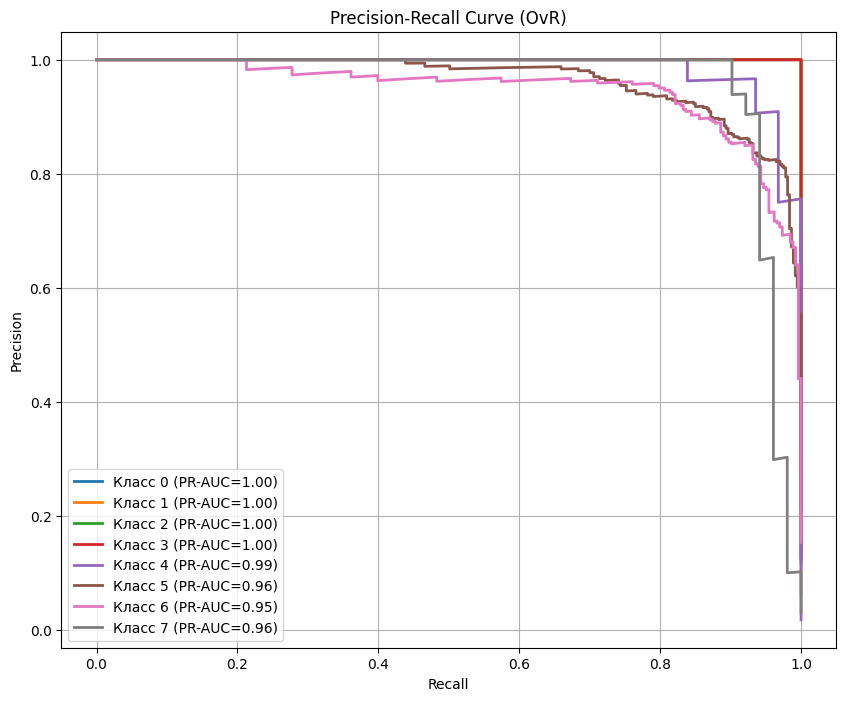

In [13]:
y_scores_np = test_preds.data if hasattr(test_preds, "data") else test_preds

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∏—Å—Ç–∏–Ω–Ω—ã–µ –º–µ—Ç–∫–∏ –≤ one-hot (–¥–ª—è OvR)
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores_np[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'–ö–ª–∞—Å—Å {i} (PR-AUC={pr_auc:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OvR)")
plt.legend()
plt.grid()
plt.show()